# Transformation between Equatorial and Galactic Coordinates

Verify that our transformation from equatorial to galactic coordinates are correct by plotting the known UHECRs from our dataset as well as some known sources.

In [34]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
import h5py

mpl.rcParams['figure.dpi'] = 300

from fancy.plotting import AllSkyMapCartopy
from fancy.interfaces import Data
from fancy.interfaces.stan import Direction
from fancy.plotting.colours import lightblue, midblue, darkblue

### Conversion from Equatorial $\leftrightarrow$ Galactic coordinates

Based on *Introduction to Modern Astrophysics (2nd Ed.)* from Carroll, Bradley and Ostlie, Dale (2007).

We work with J2000.0 Equatorial Coordinates, so that the equatorial coordinates of the North galactic pole (where glat = 90 degrees) is: 
$(\alpha_\mathrm{NGP}, \delta_\mathrm{NGP}) = (192.8583^\circ, 27.1283^\circ)$. The galactic longitude of the North Celestial Pole is:
$l_\mathrm{NCP} = 122.932^\circ$.

In [35]:
'''Quick function to transform ra[hms], dec[dms] -> ra[deg], dec[deg]'''


def hmsdms_to_degdeg(ra_hms, dec_dms, sep=" "):
    '''ra_hms, dec_dms are both strings separated by sep'''
    ra_hms_list = ra_hms.split(sep)
    dec_dms_list = dec_dms.split(sep)

    ra_deg = 15 * (float(ra_hms_list[0]) + float(ra_hms_list[1]) / 60 +
                   float(ra_hms_list[2]) / 3600)
    dec_deg = (float(dec_dms_list[0]) + float(dec_dms_list[1]) / 60 +
               float(dec_dms_list[2]) / 3600)
    return ra_deg, dec_deg


In [150]:
hmsdms_to_degdeg("17 45 39.60213", "-29 00 22.0000")

(266.41500887499996, -28.99388888888889)

In [131]:
def eq_to_gal(ra, dec, ra_NGP=192.8583, dec_NGP=27.1283, glon_NCP=122.932):
    '''Convert from J2000.0 equatorial coordinates to galactic coordinates'''

    # convert to radians
    ra_diff_rad = np.deg2rad(ra - ra_NGP)
    dec_rad = np.deg2rad(dec)
    dec_NGP_rad = np.deg2rad(dec_NGP)

    # get gal. latitude first
    sin_glat = np.sin(dec_NGP_rad) * np.sin(dec_rad) + np.cos(
        dec_NGP_rad) * np.cos(dec_rad) * np.cos(ra_diff_rad)
    glat = np.rad2deg(np.arcsin(sin_glat))

    # get gal. lon.
    sin_glon_diff = np.cos(dec_rad) * np.sin(ra_diff_rad)
    cos_glon_diff = np.cos(dec_NGP_rad) * np.sin(dec_rad) - np.sin(
        dec_NGP_rad) * np.cos(dec_rad) * np.cos(ra_diff_rad)
    glon = glon_NCP - np.rad2deg(np.arctan2(sin_glon_diff, cos_glon_diff))
    # since we define our coordinate system from 0 to 360
    glon = 360 + glon if glon < 0 else glon

    return glon, glat


def gal_to_eq(glon, glat, ra_NGP=192.8583, dec_NGP=27.1283, glon_NCP=122.932):
    '''Convert from galactic coordinates to J2000.0 equatorial coordinates'''
    # convert to radians
    glon_diff_rad = np.deg2rad(glon_NCP - glon)
    glat_rad = np.deg2rad(glat)
    dec_NGP_rad = np.deg2rad(dec_NGP)

    # get declination first
    sin_dec = np.sin(dec_NGP_rad) * np.sin(glat_rad) + np.cos(
        dec_NGP_rad) * np.cos(glat_rad) * np.cos(glon_diff_rad)
    dec = np.rad2deg(np.arcsin(sin_dec))

    # get right ascension
    sin_ra_diff = np.cos(glat_rad) * np.sin(glon_diff_rad)
    cos_ra_diff = (
        np.cos(dec_NGP_rad) * np.sin(glat_rad) -
        np.sin(dec_NGP_rad) * np.cos(glat_rad) * np.cos(glon_diff_rad))

    ra = np.rad2deg(np.arctan2(sin_ra_diff, cos_ra_diff)) + ra_NGP

    return ra, dec


def eqs_to_gals(ras, decs, ra_NGP=192.8583, dec_NGP=27.1283, glon_NCP=122.932):
    '''Vectorized version of eq -> gal coordinates'''
    return np.vectorize(eq_to_gal, excluded=[2, 3, 4])(ras, decs)


def gals_to_eqs(glons,
                glats,
                ra_NGP=192.8583,
                dec_NGP=27.1283,
                glon_NCP=122.932,):
    '''Vectorized version of gal -> eq coordinates'''
    return np.vectorize(gal_to_eq, excluded=[2, 3, 4])(glons, glats)


## Checking with Galactic Center, Galactic Anti-Center, and Galactic Plane

Verify that the coordinate tranformations work with the positions of the Galactic and Anti-Galactic Center obtained from the SIMBAD database. We also plot the Galactic Plane, which is the equator in galactic coordinates.

The right ascension and declination of the galactic center and galactic anti-center (in the J2000.0 epoch) is given as: $(\alpha_\mathrm{GC}, \delta_\mathrm{GC}) = (266.415^\circ, -28.994^\circ)$, $(\alpha_\mathrm{GA}, \delta_\mathrm{GA}) = (86.405^\circ, -28.936^\circ)$.

To check the galactic plane, we observe if the GC and GA are both passing through the galactic plane in both coordinate systems.

In [152]:
# analytical values of Galactic Center and Galactic Anti-Center
ra_gc, dec_gc = 266.41500887499996, -28.99388888888889
glon_gc, glat_gc = 0, 0
ra_ga, dec_ga = 86.405, 28.93611111111111
glon_ga, glat_ga = 180., 0.


# position of Galactic Center from transformation
glon_gc_transf, glat_gc_transf = eq_to_gal(ra_gc, dec_gc)
ra_gc_transf, dec_gc_transf = gal_to_eq(glon_gc, glat_gc)

# position of Galactic Anticenter
glon_ga_transf, glat_ga_transf = eq_to_gal(ra_ga, dec_ga)
ra_ga_transf, dec_ga_transf = gal_to_eq(glon_ga, glat_ga)

# get galactic plane
glons_gp = np.linspace(0, 360, 100)
glats_gp = np.zeros_like(glons_gp)

ras_gp, decs_gp = gals_to_eqs(glons_gp, glats_gp)

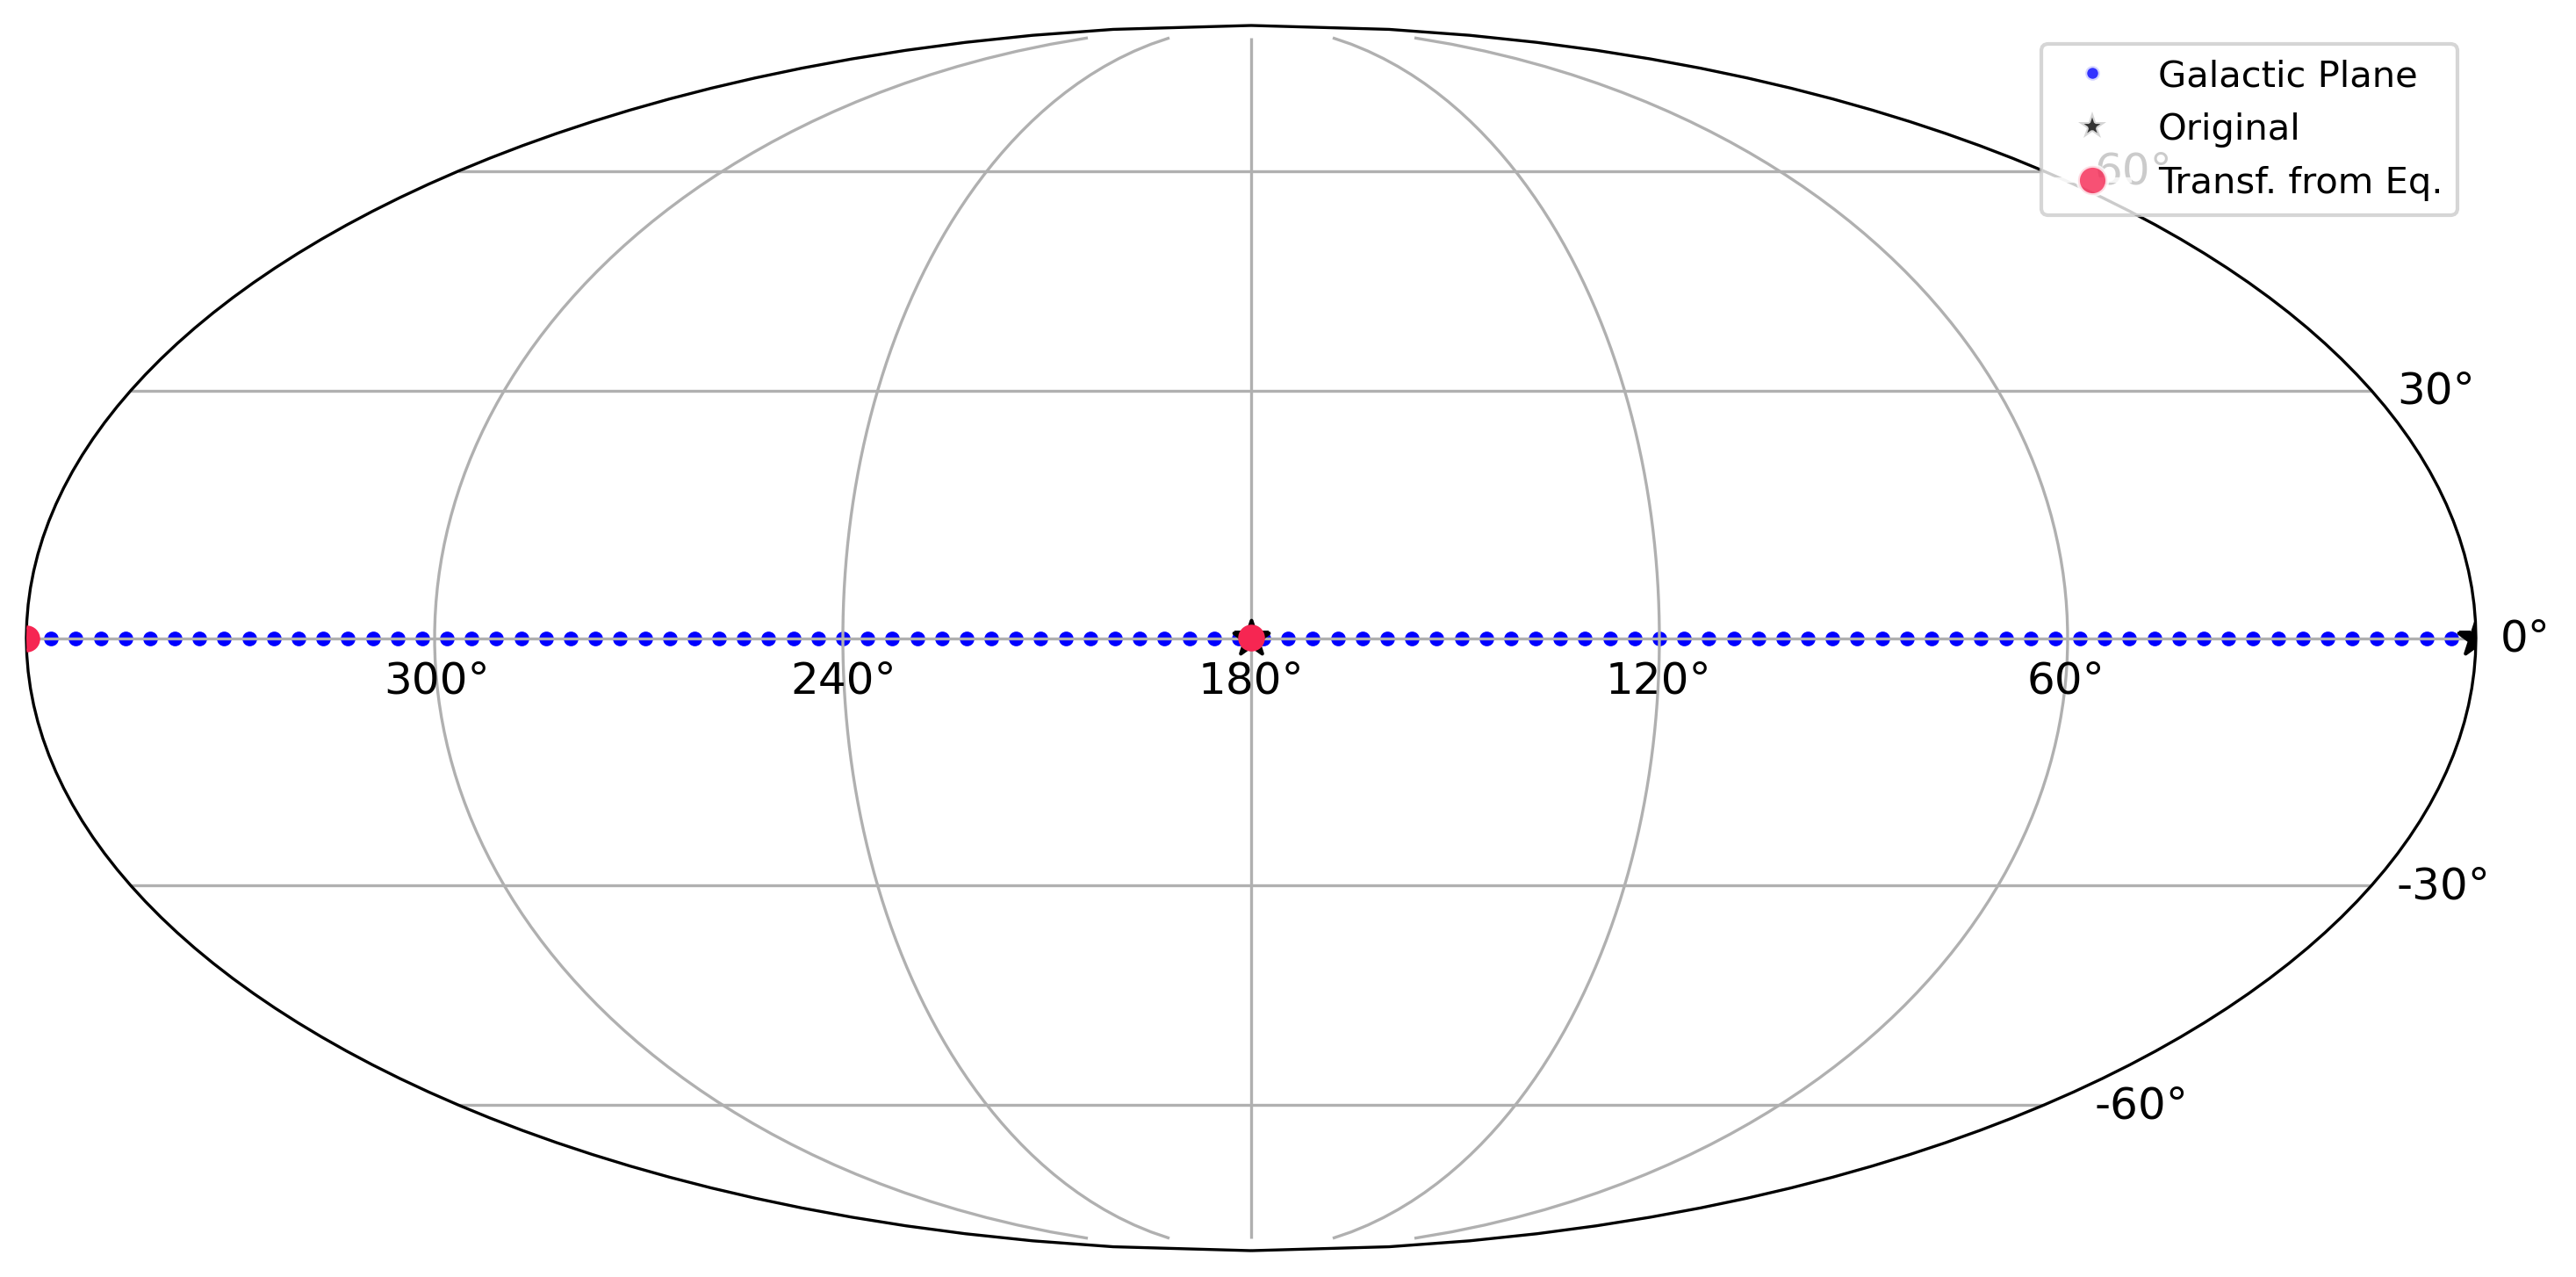

In [179]:
skymap = AllSkyMapCartopy(lon_0=180.)
skymap.set_gridlines(ypadding=10.)

# plot known sources
transform_ax = skymap.transform._as_mpl_transform(skymap.ax)

# plot galactic plane
skymap.ax.plot(glons_gp, glats_gp, marker="o", ms=3.0, ls="", label="Galactic Plane", color="b", transform=skymap.transform,)

# plot galactic center
for i, (glon, glat) in enumerate([(glon_gc, glat_gc), (glon_ga, glat_ga)]):
    skymap.scatter(glon,
                glat,
                color="k",
                alpha=1.0,
                zorder=20,
                marker="*",
                s=100.0,)

for i, (glon, glat) in enumerate([(glon_gc_transf, glat_gc_transf), (glon_ga_transf, glat_ga_transf)]):
    skymap.scatter(glon,
                glat,
                color="#f62652",
                alpha=1.0,
                zorder=22,
                marker="o",
                s=40.0,)

legend_elements = [
    mpl.lines.Line2D([0], [0],
                    marker="o",
                    color="w",
                    markersize=4,
                     markerfacecolor='b',
                     label='Galactic Plane',
                     alpha=0.8),
    mpl.lines.Line2D([0], [0],
                     marker='*',
                     color='w',
                     label='Original',
                     markersize=8,
                     markerfacecolor="k",
                     alpha=0.8),
    mpl.lines.Line2D([0], [0],
                     marker='o',
                     color='w',
                     label='Transf. from Eq.',
                     markersize=8,
                     markerfacecolor="#f62652",
                     alpha=0.8),
]

skymap.ax.legend(handles=legend_elements)

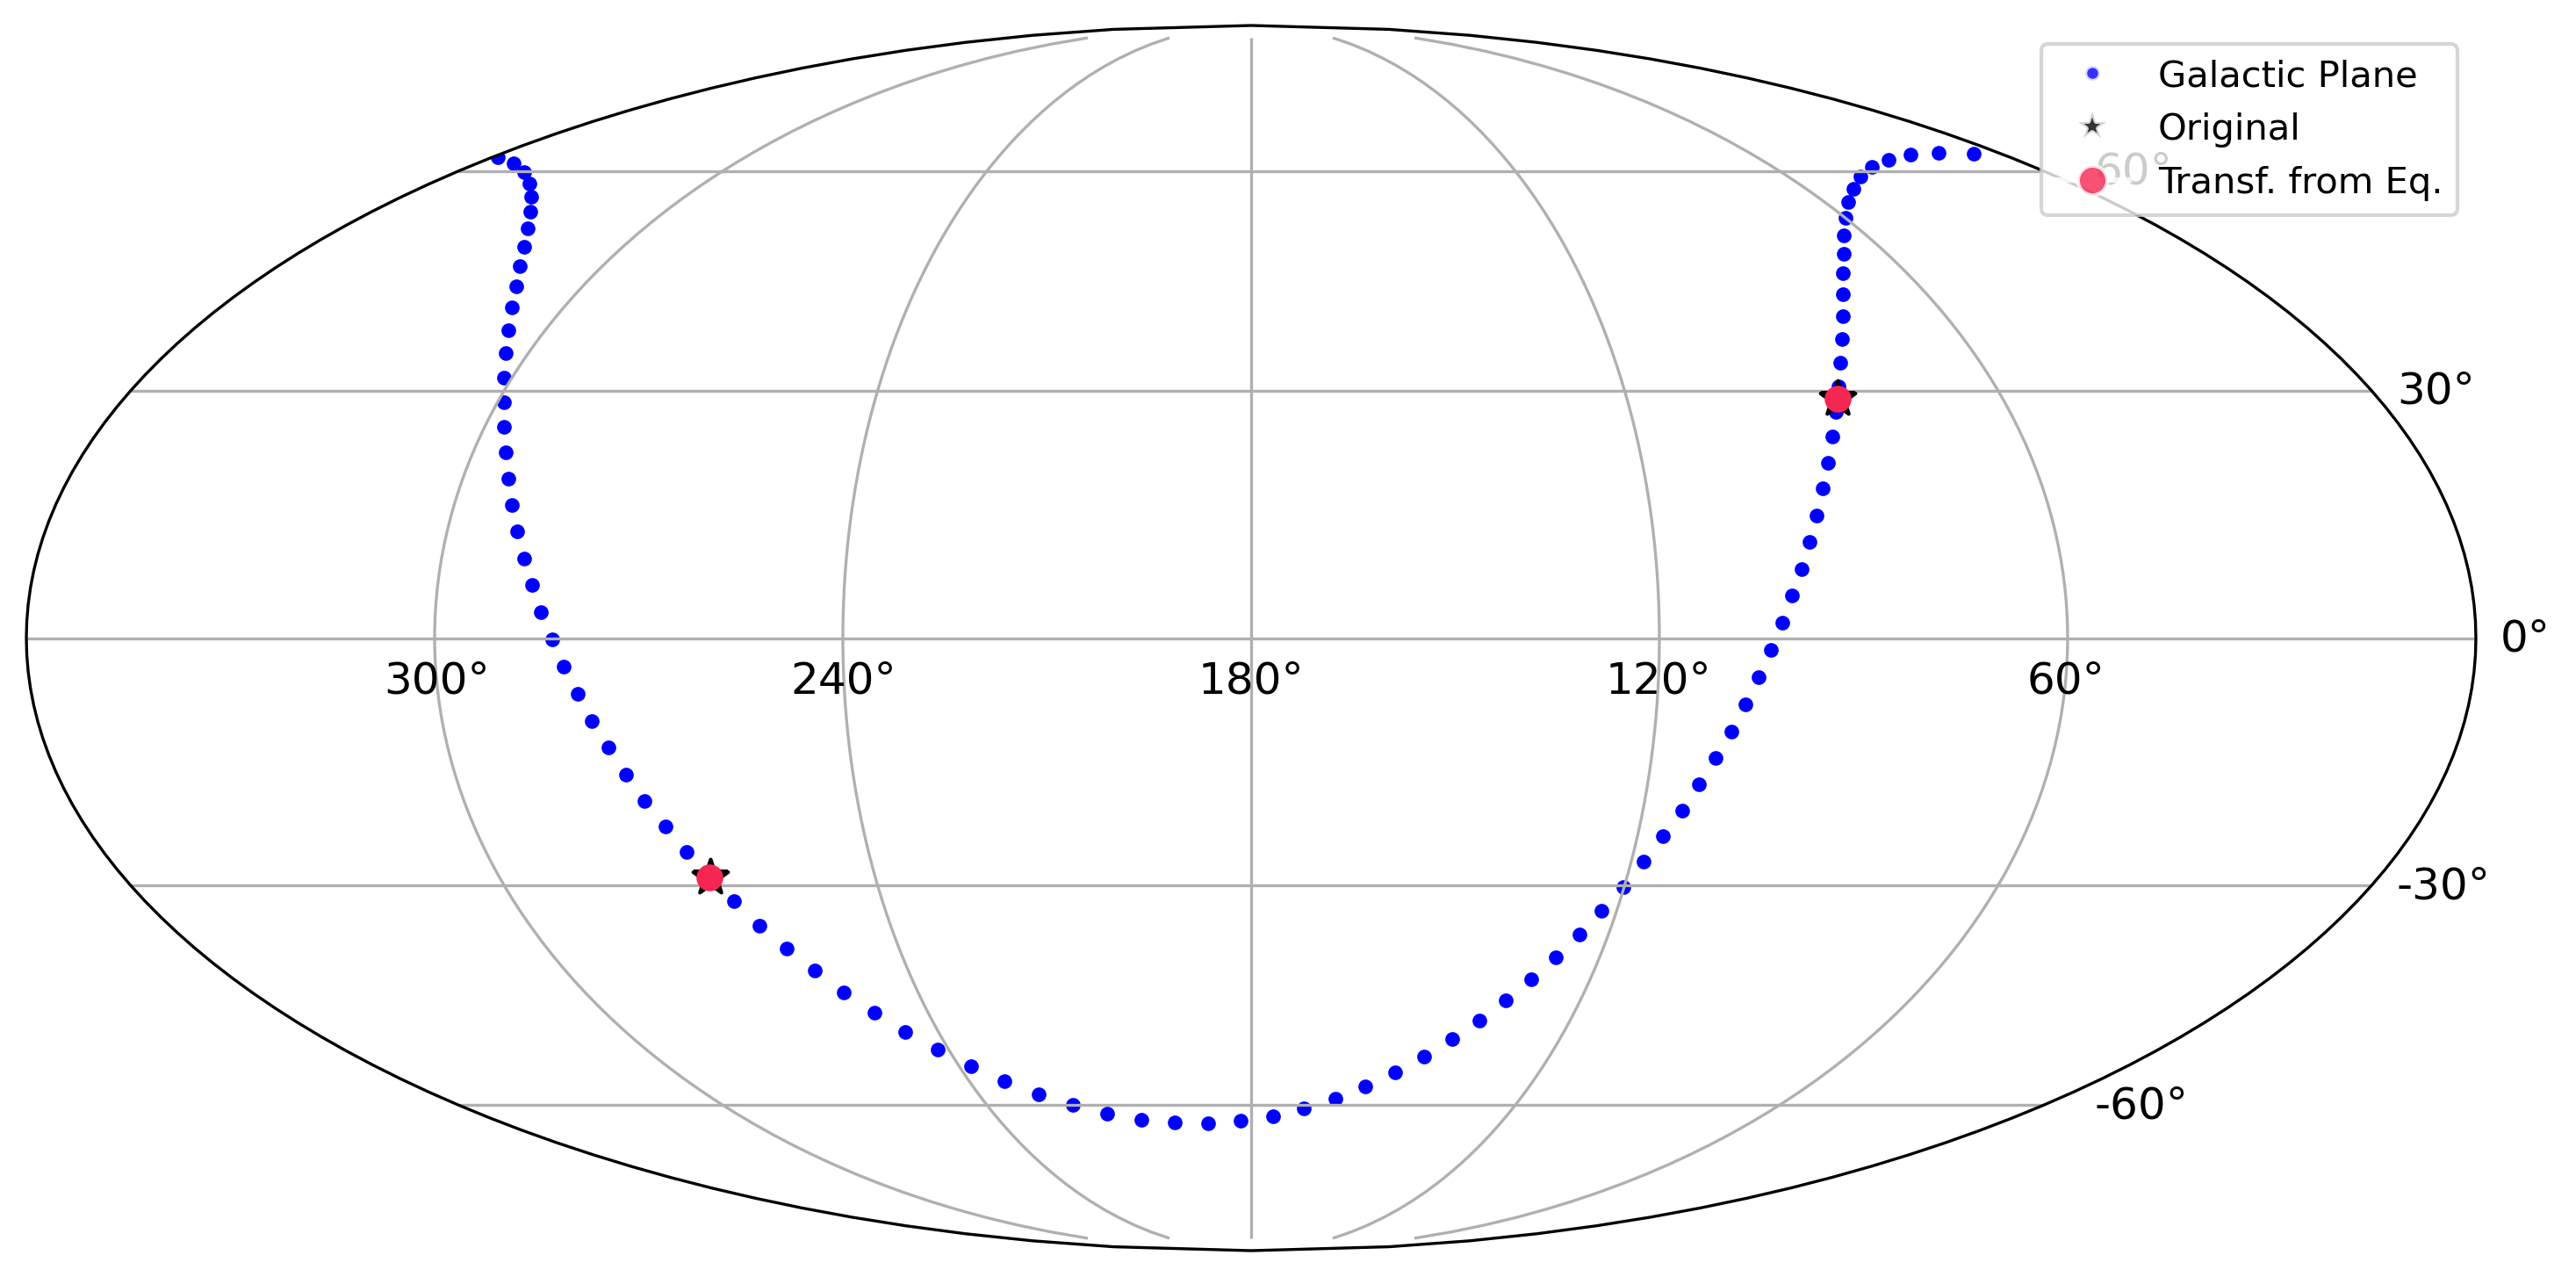

In [180]:
skymap = AllSkyMapCartopy(lon_0=180.)
skymap.set_gridlines(ypadding=10.)

# plot known sources
transform_ax = skymap.transform._as_mpl_transform(skymap.ax)

# plot galactic plane
skymap.ax.plot(ras_gp, decs_gp, marker="o", ms=3.0, ls="", label="Galactic Plane", color="b", transform=skymap.transform,)

# plot galactic center
for i, (ra, dec) in enumerate([(ra_gc, dec_gc), (ra_ga, dec_ga)]):
    skymap.scatter(ra,
                dec,
                color="k",
                alpha=1.0,
                zorder=20,
                marker="*",
                s=100.0,)

for i, (ra, dec) in enumerate([(ra_gc_transf, dec_gc_transf), (ra_ga_transf, dec_ga_transf)]):
    skymap.scatter(ra,
                dec,
                color="#f62652",
                alpha=1.0,
                zorder=22,
                marker="o",
                s=40.0,)

legend_elements = [
    mpl.lines.Line2D([0], [0],
                    marker="o",
                    color="w",
                    markersize=4,
                     markerfacecolor='b',
                     label='Galactic Plane',
                     alpha=0.8),
    mpl.lines.Line2D([0], [0],
                     marker='*',
                     color='w',
                     label='Original',
                     markersize=8,
                     markerfacecolor="k",
                     alpha=0.8),
    mpl.lines.Line2D([0], [0],
                     marker='o',
                     color='w',
                     label='Transf. from Eq.',
                     markersize=8,
                     markerfacecolor="#f62652",
                     alpha=0.8),
]

skymap.ax.legend(handles=legend_elements)

## Checking with Known sources

Verify that our coordinate transformations are performed correctly by plotting againts the coordinates of known sources as obtained from [SIMBAD database](http://simbad.cds.unistra.fr/simbad/).

In [132]:
'''Get some known coordinates to compare to'''
names_known_srcs = [
    "Cen A", "M87", "M82", "M83", "NGC253", "NGC6946", "IC342", "NGC4945",
    "NGC4395", "M106"
]
glons_known_srcs = np.array([
    309.55923, 283.7254, 141.409462, 314.58357, 97.363768, 95.71876,
    138.172576, 305.271539, 162.20886952, 138.31448603
])
glats_known_srcs = np.array([
    19.403927, 74.5294, 40.566959, 31.972703, -87.964548, 11.672735, 10.579852,
    13.340164, 81.54309170, 68.85666124
])

textloc_known_srcs = [(-5, 15), (30, -5), (-5, -5), (-5, 15), (0, -5),
                      (45, -5), (5, 15), (-5, 10), (0, 20), (30, -5)]

# get ras, decs for each known source in strings
eqcoords_known_srcs = [("13 25 27.6039817176", "-43 01 09.493008456"),
                       ("12 30 49.42338230", "+12 23 28.0438581"),
                       ("09 55 52.430", "+69 40 46.93"),
                       ("13 37 00.91920", "-29 51 56.7400"),
                       ("00 47 33.134", "-25 17 19.68"),
                       ("20 34 52.332", "+60 09 13.24"),
                       ("03 46 48.514", "+68 05 45.98"),
                       ("13 05 27.279", "-49 28 04.44"),
                       ("12 25 48.8633109888", "+33 32 48.700168152"),
                       ("12 18 57.620", "+47 18 13.39")]

# convert to decimal degrees
ras_known_srcs = np.zeros_like(glons_known_srcs)
decs_known_srcs = np.zeros_like(glons_known_srcs)
for i, (ra_hms, dec_dms) in enumerate(eqcoords_known_srcs):
    ras_known_srcs[i], decs_known_srcs[i] = hmsdms_to_degdeg(ra_hms, dec_dms)

# print(ras_known_srcs, decs_known_srcs)

In [ ]:
# now get glons, glats from our user defined transformation function
glons_known_srcs_transf, glats_known_srcs_transf = eqs_to_gals(
    ras_known_srcs, decs_known_srcs)

# get ras, decs from our user defined transformation function
ras_known_srcs_transf, decs_known_srcs_transf = gals_to_eqs(
    glons_known_srcs, glats_known_srcs)


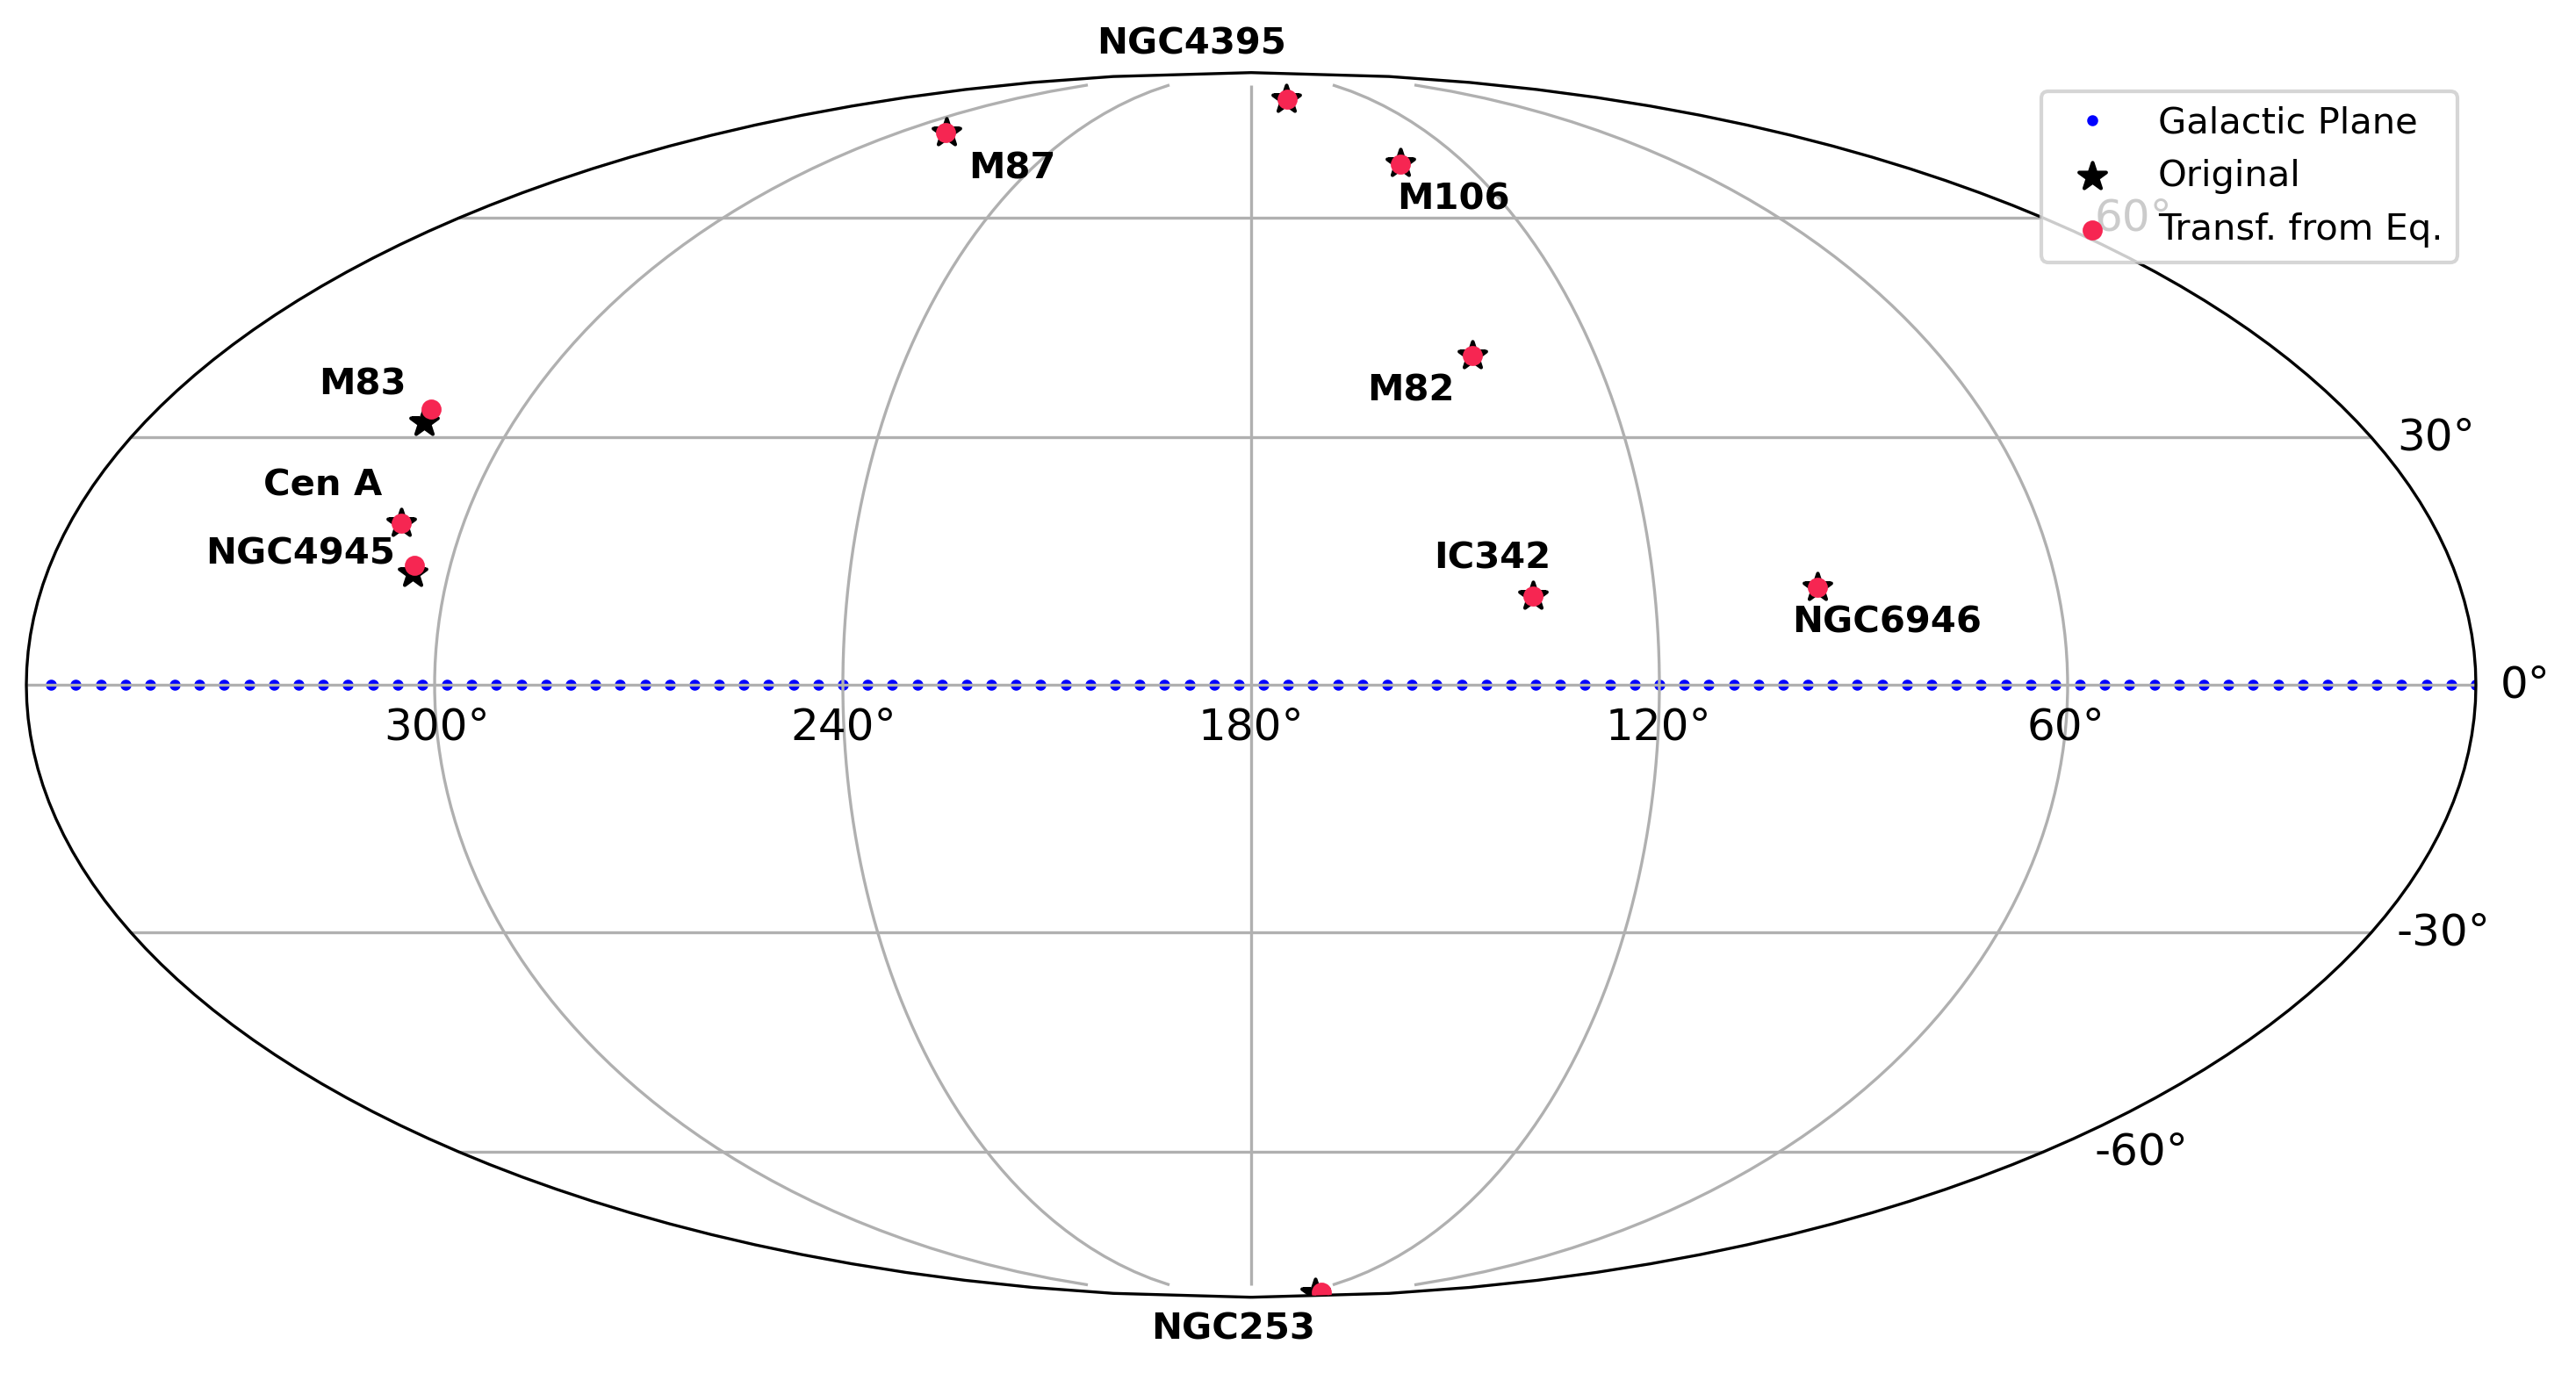

In [181]:
skymap = AllSkyMapCartopy(lon_0=180.)
skymap.set_gridlines(ypadding=10.)

# plot known sources
transform_ax = skymap.transform._as_mpl_transform(skymap.ax)

# plot galactic plane
skymap.ax.plot(glons_gp, glats_gp, marker="o", ms=2.0, ls="", label="Galactic Plane", color="b", transform=skymap.transform,)

src_color = "k"
skymap.scatter(glons_known_srcs,
               glats_known_srcs,
               color=src_color,
               alpha=1.0,
               zorder=20,
               marker="*",
               s=60.0,
               label="Original")

srcname_color = "k"
for i, (lon, lat) in enumerate(np.nditer([glons_known_srcs,
                                          glats_known_srcs])):
    skymap.ax.annotate(names_known_srcs[i], (lon, lat),
                       xycoords=transform_ax,
                       ha="right",
                       va="top",
                       zorder=40,
                       textcoords='offset points',
                       xytext=textloc_known_srcs[i],
                       color=srcname_color,
                       weight='bold',
                       fontsize=10)

# plot transformed coordinates
skymap.scatter(glons_known_srcs_transf,
               glats_known_srcs_transf,
               color='#f62652',
               alpha=1.0,
               zorder=20,
               marker="o",
               s=20.0,
               label="Transf. from Eq.")

skymap.ax.legend()


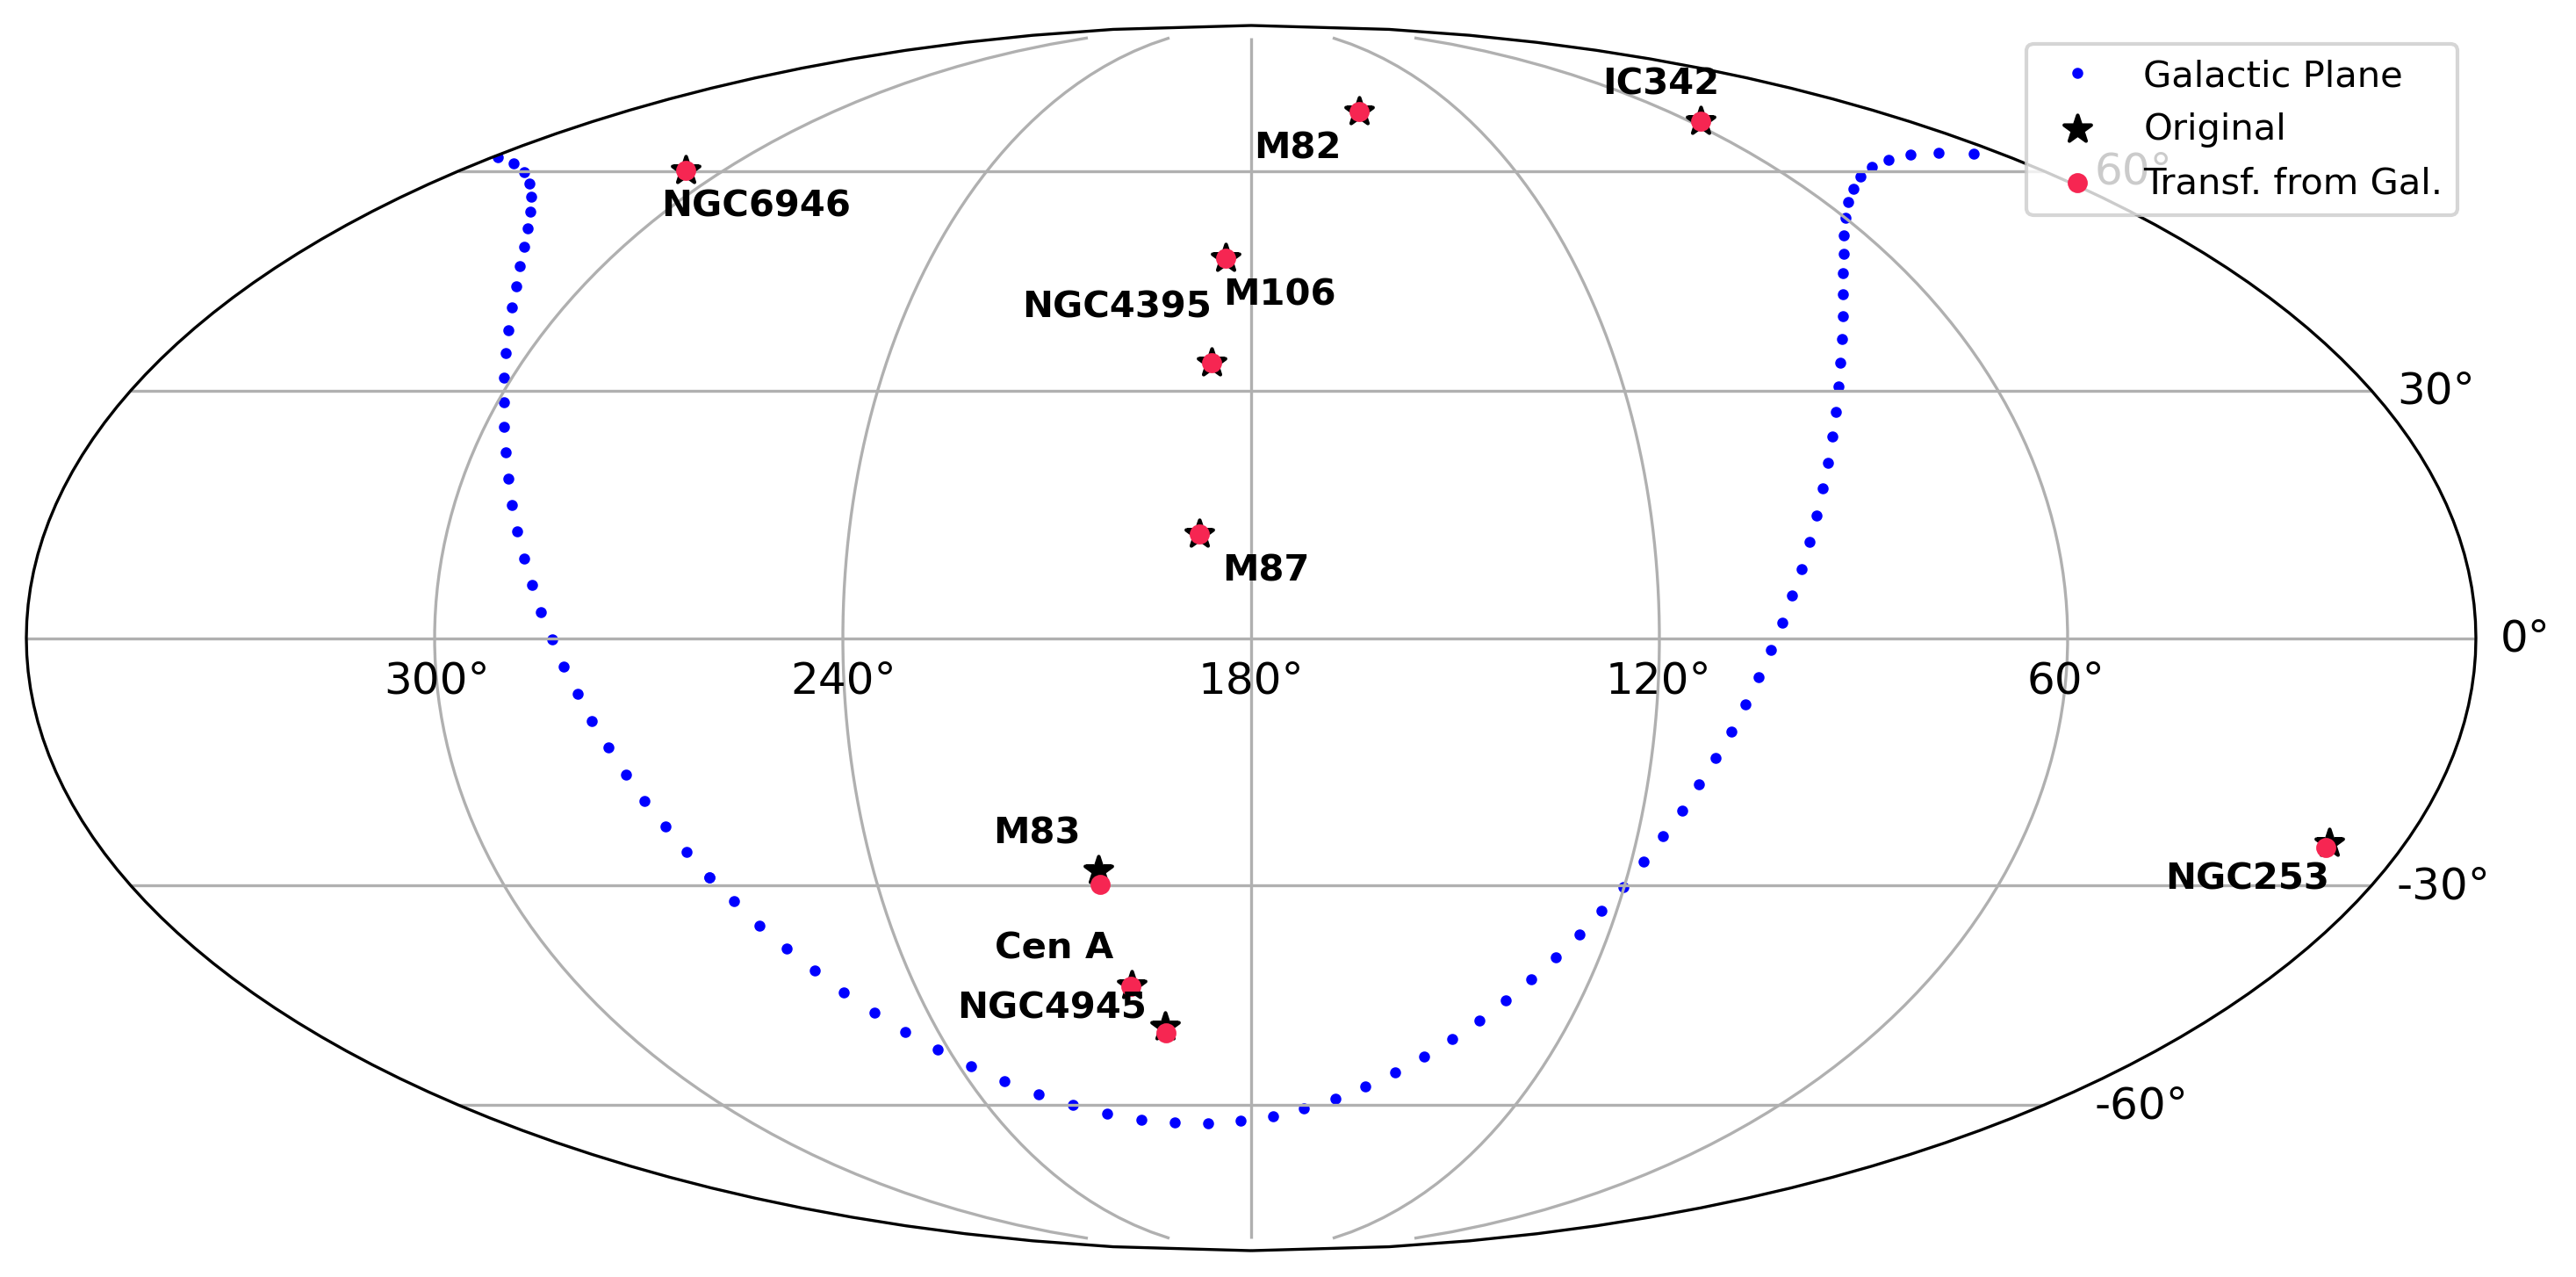

In [182]:
skymap = AllSkyMapCartopy(lon_0=180.)
skymap.set_gridlines(ypadding=10.)

# plot known sources
transform_ax = skymap.transform._as_mpl_transform(skymap.ax)

# plot galactic plane
skymap.ax.plot(ras_gp, decs_gp, marker="o", ms=2.0, ls="", label="Galactic Plane", color="b", transform=skymap.transform,)

src_color = "k"
skymap.scatter(ras_known_srcs,
               decs_known_srcs,
               color=src_color,
               alpha=1.0,
               zorder=20,
               marker="*",
               s=60.0,
               label="Original")

srcname_color = "k"
for i, (lon, lat) in enumerate(np.nditer([ras_known_srcs, decs_known_srcs])):
    skymap.ax.annotate(names_known_srcs[i], (lon, lat),
                       xycoords=transform_ax,
                       ha="right",
                       va="top",
                       zorder=40,
                       textcoords='offset points',
                       xytext=textloc_known_srcs[i],
                       color=srcname_color,
                       weight='bold',
                       fontsize=10)

# plot transformed coordinates
skymap.scatter(ras_known_srcs_transf,
               decs_known_srcs_transf,
               color='#f62652',
               alpha=1.0,
               zorder=20,
               marker="o",
               s=20.0,
               label="Transf. from Gal.")

skymap.ax.legend()


### Checking with UHECRs

Verify our coordinate transformations with the UHECR datasets.

In [143]:
'''Preliminary Preparations'''

uhecr_file = "../data/UHECRdata.h5"
detector_type = "TA2015"

if detector_type == "TA2015":
    from fancy.detector.TA2015 import detector_properties, detector_params
elif detector_type == "auger2014":
    from fancy.detector.auger2014 import detector_properties, detector_params
elif detector_type == "auger2010":
    from fancy.detector.auger2010 import detector_properties, detector_params
else:
    raise Exception("Undefined detector type!")
'''info used for plotting sources & UHECRs'''
data = Data()
data.add_uhecr(uhecr_file, detector_type)
data.add_detector(detector_properties)

arrival_direction = Direction(data.uhecr.unit_vector)
energy = data.uhecr.energy

# plotting info for UHECRs
uhecr_color = [lightblue, midblue, darkblue]
uhecr_cmap = mpl.colors.ListedColormap(uhecr_color)
energy_bins = np.logspace(np.log(57), np.log(170), 4, base=np.e)
uhecr_norm = mpl.colors.BoundaryNorm(energy_bins, uhecr_cmap.N)
'''Get converted glons, glats from initial ra, dec of dataset'''
with h5py.File(uhecr_file, "r") as f:
    ras_data = f[detector_type]["ra"][()]
    decs_data = f[detector_type]["dec"][()]

# convert to glat, glon
glons_transf, glats_transf = eqs_to_gals(ras_data, decs_data)

# convert to ras, decs
ras_transf, decs_transf = gals_to_eqs(arrival_direction.glons,
                                      arrival_direction.glats)


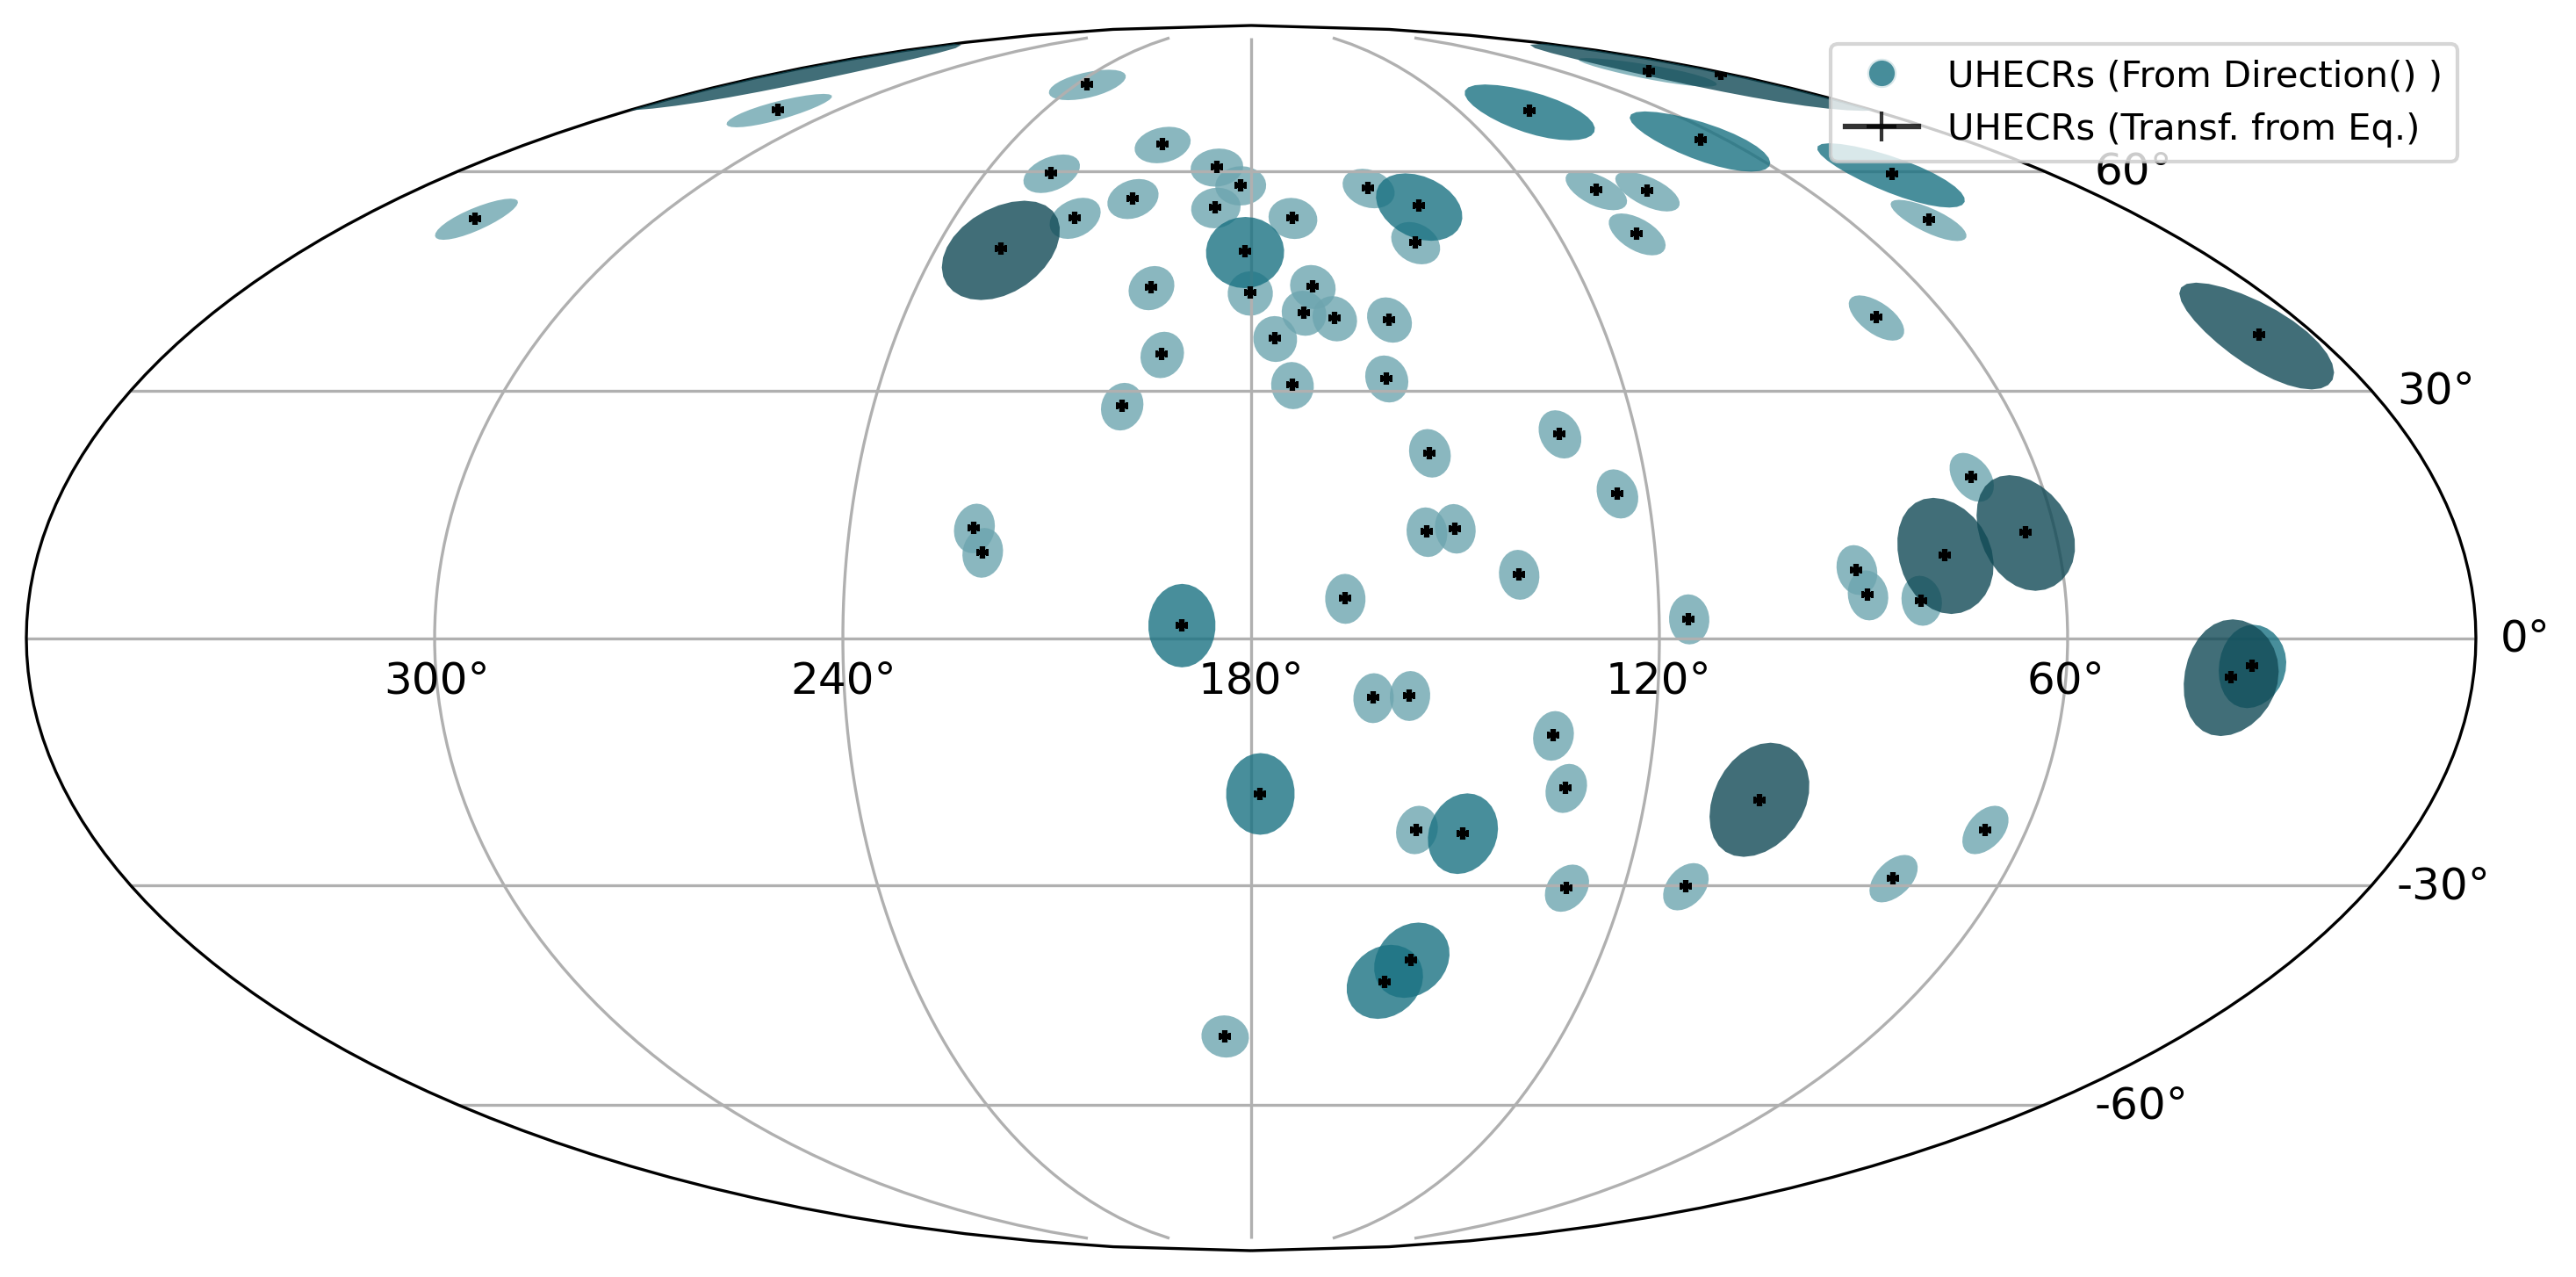

In [144]:
'''Plot skymap'''
skymap = AllSkyMapCartopy(lon_0=180.)
skymap.set_gridlines(ypadding=10.)

# UHECRs
for lon, lat, E in np.nditer(
    [arrival_direction.glons, arrival_direction.glats, energy]):
    i = np.digitize(E, energy_bins) - 1
    skymap.tissot(
        lon,
        lat,
        3.0 + (i * 2),
        npts=30,
        lw=0,
        color=uhecr_cmap.colors[i],
        alpha=0.8,
        zorder=i + 2,
    )

# UHECRs from function
skymap.scatter(glons_transf, glats_transf, c="k", marker="+", s=10.0, zorder=5)

# Legend
legend_elements = [
    mpl.lines.Line2D([0], [0],
                     marker='o',
                     color='w',
                     label='UHECRs (From Direction() )',
                     markersize=8,
                     markerfacecolor=midblue,
                     alpha=0.8),
    mpl.lines.Line2D([0], [0],
                     marker='+',
                     color='k',
                     label='UHECRs (Transf. from Eq.)',
                     markersize=8,
                     markerfacecolor="k",
                     alpha=0.8),
]

skymap.ax.legend(handles=legend_elements)

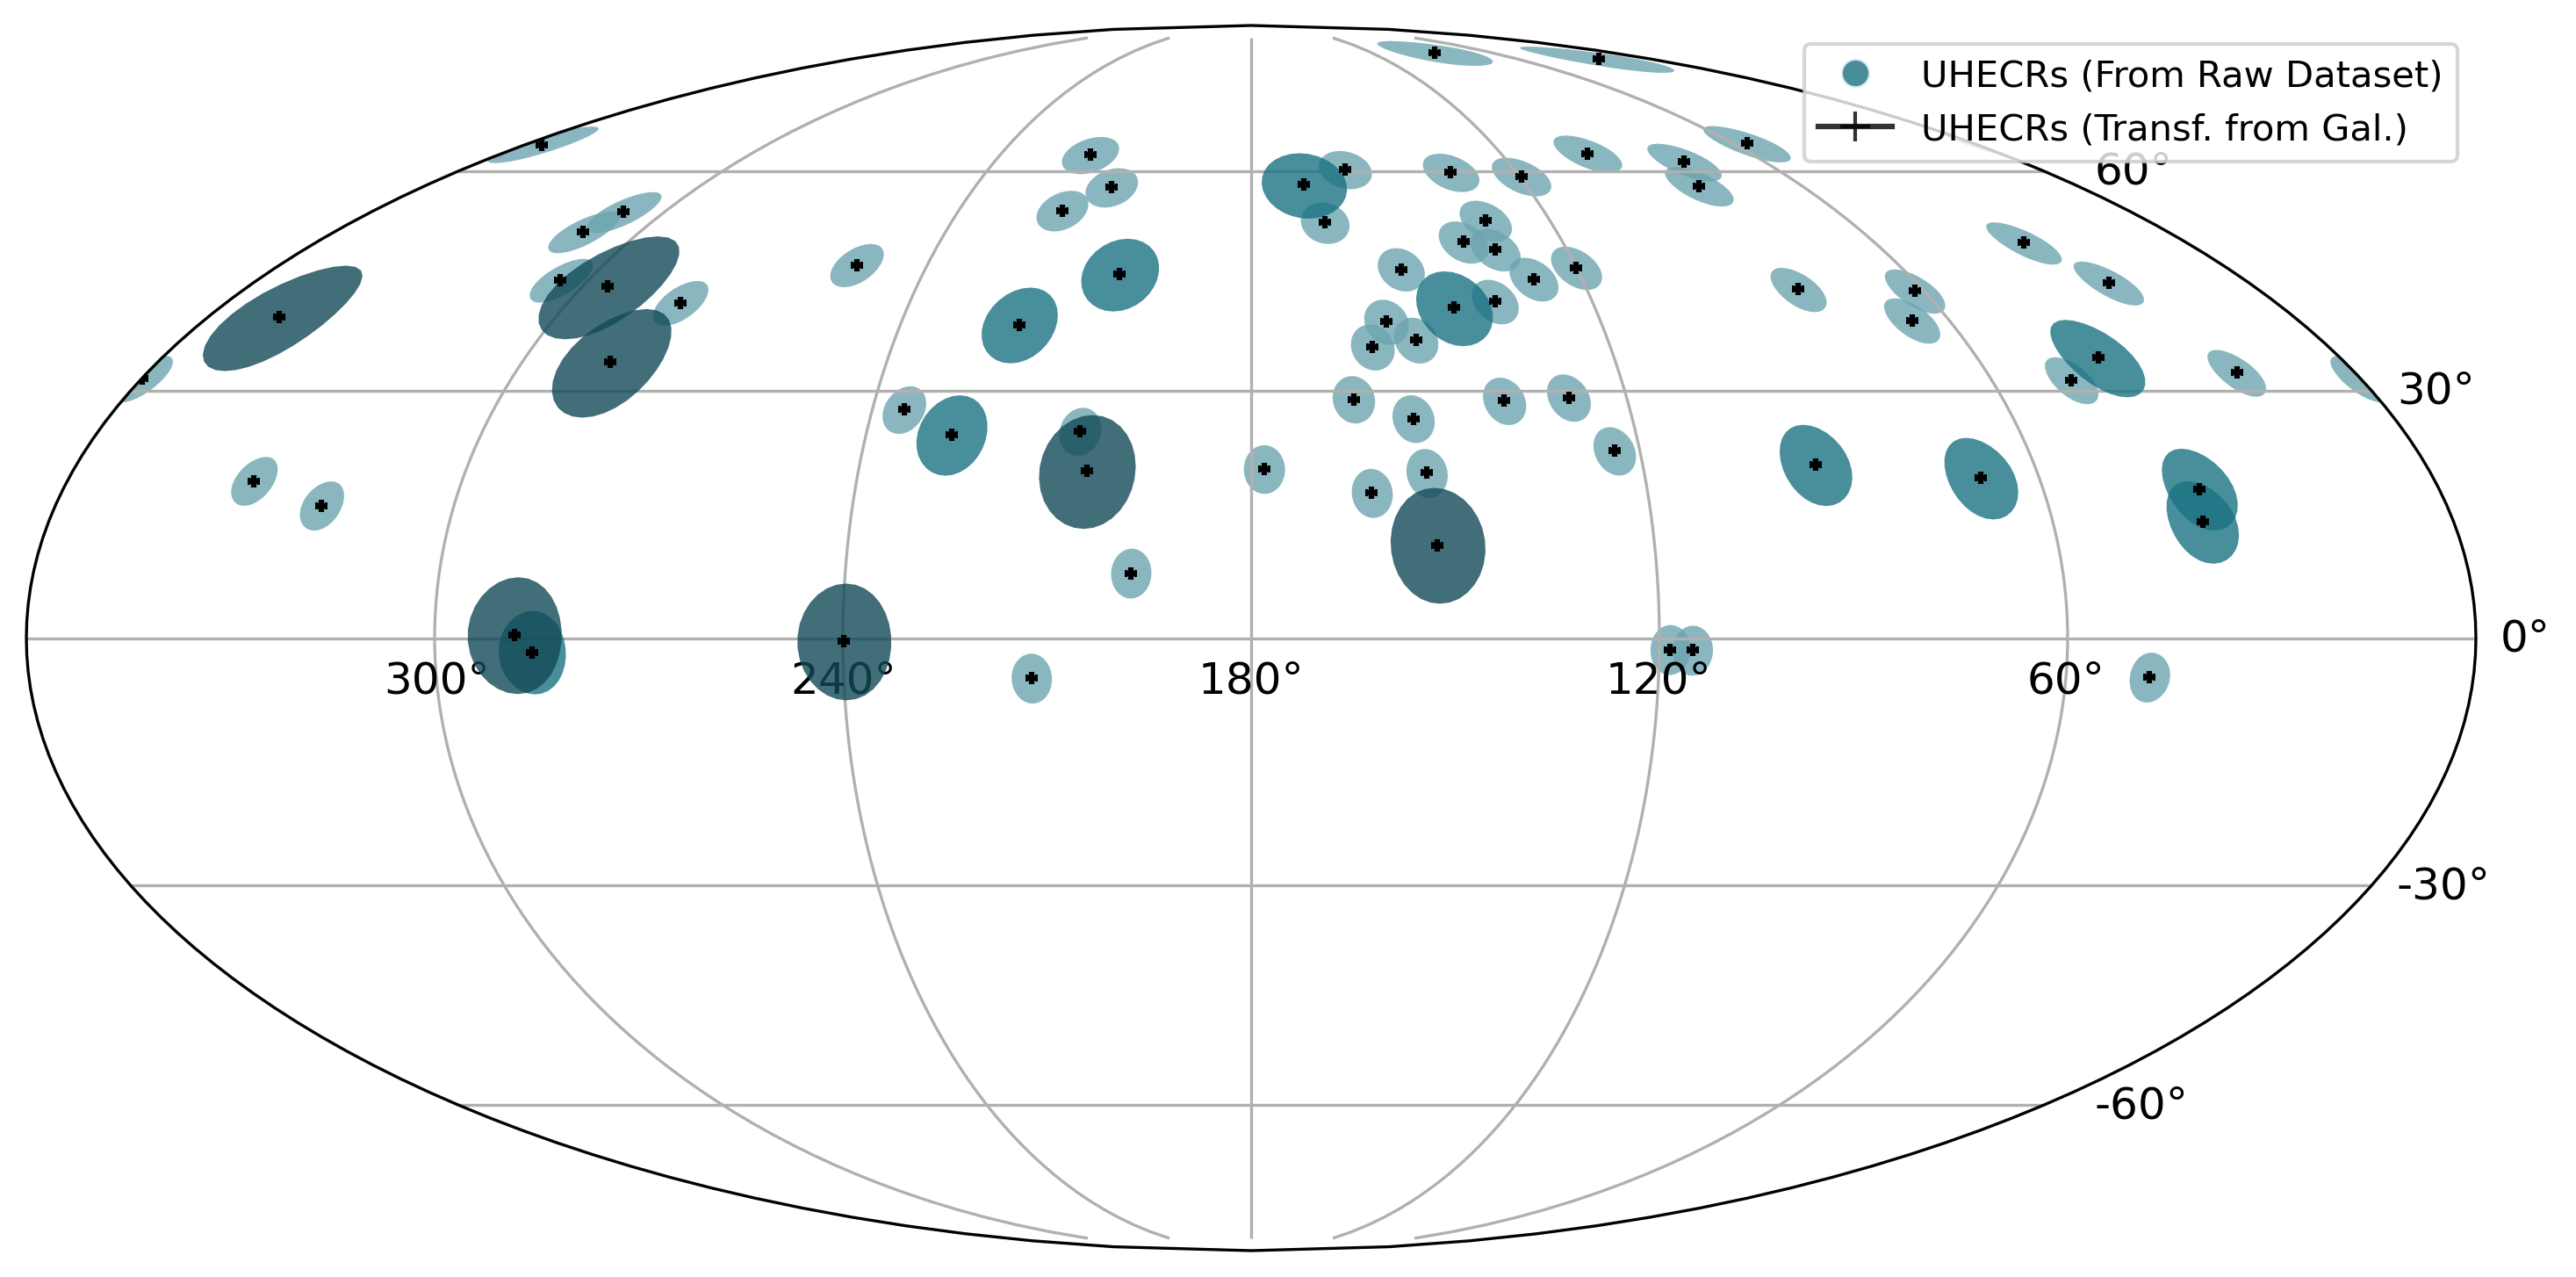

In [145]:
'''Plot skymap'''
skymap = AllSkyMapCartopy(lon_0=180.)
skymap.set_gridlines(ypadding=10.)

# UHECRs
for lon, lat, E in np.nditer([ras_data, decs_data, energy]):
    i = np.digitize(E, energy_bins) - 1
    skymap.tissot(
        lon,
        lat,
        3.0 + (i * 2),
        npts=30,
        lw=0,
        color=uhecr_cmap.colors[i],
        alpha=0.8,
        zorder=i + 2,
    )

# UHECRs from function
skymap.scatter(ras_transf, decs_transf, c="k", marker="+", s=10.0, zorder=5)

# Legend
legend_elements = [
    mpl.lines.Line2D([0], [0],
                     marker='o',
                     color='w',
                     label='UHECRs (From Raw Dataset)',
                     markersize=8,
                     markerfacecolor=midblue,
                     alpha=0.8),
    mpl.lines.Line2D([0], [0],
                     marker='+',
                     color='k',
                     label='UHECRs (Transf. from Gal.)',
                     markersize=8,
                     markerfacecolor="k",
                     alpha=0.8),
]

skymap.ax.legend(handles=legend_elements)